Notebook to do multiclass classification of the trees into banana, cacao and other categories using ResNet-18.

Author: Payel Mukhopadhyay

In [1]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
from  torch import optim 
import pandas as pd
from skimage import io, transform
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
from torchvision.transforms.functional import pad
import cv2
import torchvision
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms
from torchvision import models
#from torchmetrics.classification import BinaryPrecision
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
final = pd.read_csv('mapping/final_dataset.csv')

In [3]:
final['banana'] = int(0)
final['cacao'] = int(0)
final['fruit'] = int(0)
final['timber'] = int(0)
final['citrus'] = int(0)
final['other'] = int(0)
final['which_class'] = int(0)

final.loc[final['group'] == 'banana', 'banana'] = int(1)
final.loc[final['group'] == 'cacao', 'cacao'] = int(1)
final.loc[final['group'] == 'fruit', 'fruit'] = int(1)
final.loc[final['group'] == 'timber', 'timber'] = int(1)
final.loc[final['group'] == 'citrus', 'citrus'] = int(1)
final.loc[final['group'] == 'other', 'other'] = int(1)

final.loc[final['group'] == 'cacao', 'which_class'] = int(1)
final.loc[final['group'] == 'fruit', 'which_class'] = int(2)
final.loc[final['group'] == 'timber', 'which_class'] = int(2)
final.loc[final['group'] == 'citrus', 'which_class'] = int(2)
final.loc[final['group'] == 'other', 'which_class'] = int(2)

In [4]:
final_small = final.sample(4663)
final_small[['group', 'banana', 'cacao', 'fruit', 'timber', 'citrus', 'other', 'which_class']]

,group,banana,cacao,fruit,timber,citrus,other,which_class
4596,cacao,0,1,0,0,0,0,1
687,banana,1,0,0,0,0,0,0
4587,fruit,0,0,1,0,0,0,2
2561,cacao,0,1,0,0,0,0,1
4645,other,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...
245,banana,1,0,0,0,0,0,0
2063,fruit,0,0,1,0,0,0,2
477,banana,1,0,0,0,0,0,0
4546,cacao,0,1,0,0,0,0,1


In [5]:
final_small['which_class'].unique()

array([1, 0, 2])

In [14]:
#train, trees_test = train_test_split(final, shuffle = True, random_state = 900, test_size = 0.2)

In [6]:
trees_train_1, trees_test = train_test_split(final_small, shuffle = True, test_size = 0.2, 
                                           stratify=final_small.which_class.values)

In [7]:
trees_train, trees_valid = train_test_split(trees_train_1, shuffle = True, test_size = 0.2, 
                                           stratify=trees_train_1.which_class.values)

In [8]:
trees_train['which_class'].unique()

array([1, 2, 0])

In [9]:
trees_valid['which_class'].unique()

array([1, 0, 2])

In [10]:
# make the training set
trees_train.to_csv('mapping/train_multiclass.csv', index = False) 

In [11]:
# make the validation set
trees_valid.to_csv('mapping/valid_multiclass.csv', index = False) 

In [12]:
# make the test set
trees_test.to_csv('mapping/test_multiclass.csv', index = False) 

In [13]:
trees_train['group'].value_counts()

cacao     1306
banana     963
fruit      474
other      108
timber      84
citrus      49
Name: group, dtype: int64

In [14]:
trees_train.groupby(by = 'group').AGB.sum()

group
banana     9010.463437
cacao      6232.645547
citrus      597.376869
fruit     11817.040909
other      3099.135752
timber     3731.623318
Name: AGB, dtype: float64

In [15]:
trees_train['site'].value_counts()

Carlos_Vera_Guevara_RGB    586
Nestor_Macias_RGB          579
Flora_Pluas_RGB            541
Leonor_Aspiazu_RGB         504
Carlos_Vera_Arteaga_RGB    469
Manuel_Macias_RGB          305
Name: site, dtype: int64

In [16]:
trees_valid['group'].value_counts()

cacao     327
banana    240
fruit     119
other      28
timber     22
citrus     10
Name: group, dtype: int64

In [17]:
trees_valid['site'].value_counts()

Carlos_Vera_Guevara_RGB    151
Flora_Pluas_RGB            132
Nestor_Macias_RGB          130
Leonor_Aspiazu_RGB         125
Carlos_Vera_Arteaga_RGB    117
Manuel_Macias_RGB           91
Name: site, dtype: int64

In [18]:
n = 200
img_name = trees_train.iloc[n, 0]
print(img_name)

Manuel_Macias_RGB_8_7600_6879_11600_10879.png


In [19]:
df_img1 = trees_train.loc[trees_train['img_path'] == img_name]
tile1 = io.imread(os.path.join('tiles/all_tiles/', img_name))

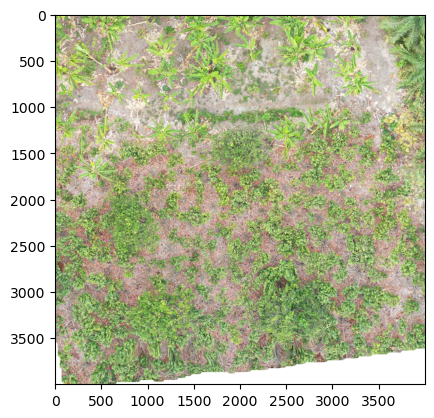

In [20]:
plt.imshow(tile1)
plt.show()

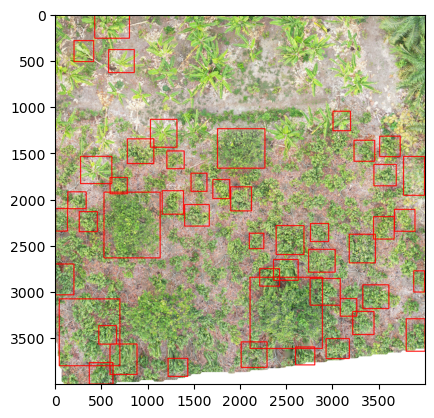

In [21]:
i = 0
for name in df_img1['img_path'].values:
    
    xmin = round(df_img1['xmin'].values[i])
    ymin = round(df_img1['ymin'].values[i])
    xmax = round(df_img1['xmax'].values[i])
    ymax = round(df_img1['ymax'].values[i])

    color = (255,0,0)
    
    tile1 = cv2.rectangle(tile1,(xmin,ymin),(xmax,ymax),color,10)
    
    i += 1
    #break

plt.imshow(tile1)   

In [22]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [23]:
preprocess = transforms.Compose([
                     transforms.Resize(224),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor()
])
                

In [24]:
class Trees(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trees_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.trees_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.trees_frame.iloc[idx, 0])
        image = Image.open(img_name)
        
        xmin = int(self.trees_frame.iloc[idx]['xmin'])
        ymin = int(self.trees_frame.iloc[idx]['ymin'])
        xmax = int(self.trees_frame.iloc[idx]['xmax'])
        ymax = int(self.trees_frame.iloc[idx]['ymax'])

        image = image.crop((xmin, ymin, xmax, ymax))
        image = expand2square(image, (0, 0, 0))
        image = preprocess(image)
        class_ = self.trees_frame.iloc[idx]['which_class']

        sample = image, int(class_)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [25]:
ttrain = Trees(csv_file='mapping/train_multiclass.csv', root_dir='tiles/all_tiles')

In [26]:
tvalid = Trees(csv_file='mapping/valid_multiclass.csv', root_dir='tiles/all_tiles')

In [27]:
ttest = Trees(csv_file='mapping/test_multiclass.csv', root_dir='tiles/all_tiles')

(array([0.02274655, 0.23279347, 0.65534641, 1.14811991, 1.41595492,
        1.69936553, 1.74185201, 1.81828969, 1.30871148, 0.23907787]),
 array([0.02745098, 0.12470588, 0.22196078, 0.31921569, 0.41647059,
        0.51372552, 0.61098039, 0.70823532, 0.8054902 , 0.90274513,
        1.        ]),
 <BarContainer object of 10 artists>)

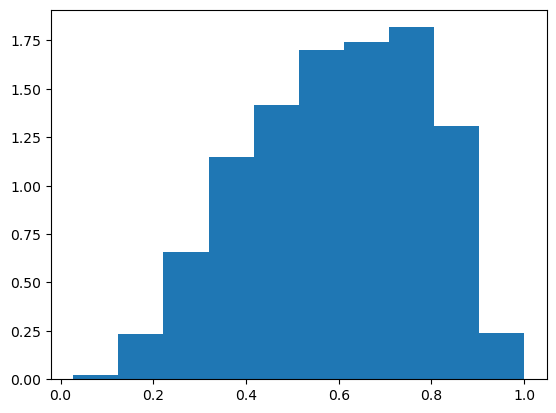

In [28]:
plt.hist(ttrain[0][0].ravel(), density=True)

class: 2


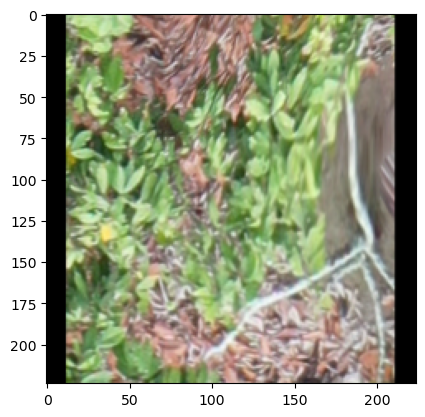

In [61]:
im, label = ttrain[1670]
plt.imshow(im.permute(1,2,0))
print('class:',label)

class: 1


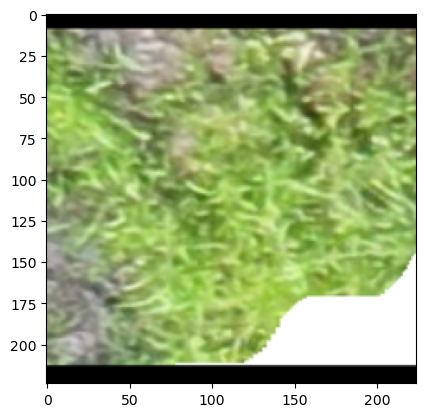

In [33]:
im, label = tvalid[740]
plt.imshow(im.permute(1,2,0))
print('class:',label)

In [ ]:
# Wrap it onto a dataloader

In [34]:
train_dataloader = DataLoader(ttrain, batch_size=128, shuffle=True)

In [35]:
valid_dataloader = DataLoader(tvalid, batch_size=128, shuffle=False)

In [36]:
test_dataloader = DataLoader(ttest, batch_size=128, shuffle=False)

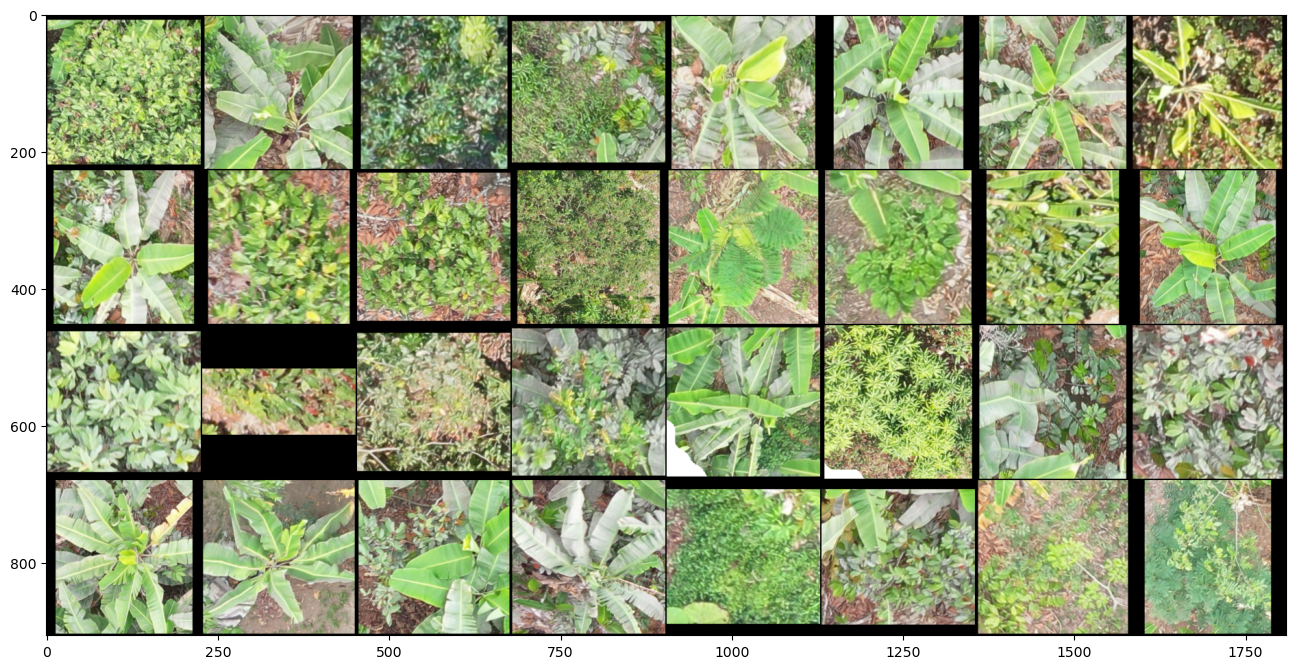

In [37]:
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [38]:
print(len(train_dataloader), len(valid_dataloader), len(test_dataloader))

24 6 8


In [39]:
print('Train dataset size:', len(ttrain))
print('Validation dataset size:', len(tvalid))
print('Test dataset size:', len(ttest))

Train dataset size: 2984
Validation dataset size: 746
Test dataset size: 933


In [73]:
model = models.resnet18(pretrained=True)
#model = torchvision.models.efficientnet_b0(pretrained = True)

In [74]:
model.fc = nn.Sequential(
     nn.Dropout(0.5),
     nn.Linear(512, 3)
)

In [75]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5, weight_decay= 1e-6, amsgrad = True)
#optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [76]:
from sklearn.utils import class_weight

In [77]:
classes=['banana','cacao','fruit','timber','citrus','other']

In [78]:
weights=torch.tensor(class_weight.compute_class_weight('balanced',classes=classes,y=trees_train['group'].to_numpy()),dtype=torch.float)

In [79]:
weights

tensor([ 0.5164,  0.3808,  1.0492,  5.9206, 10.1497,  4.6049])

In [80]:
weights_3class = torch.tensor([1.03, 0.76, 1.39])

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Setup the loss function
#device = "cpu"
criterion = nn.CrossEntropyLoss(weight=weights_3class.to(device))

In [82]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [83]:
train_loss = []
train_acc = []

val_loss = []
val_acc = []

epochs = 10

if torch.cuda.is_available():
    model.cuda()

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
      model.train()
      for image,label in train_dataloader:
          image, label = image.to(device), label.to(device)
          optimizer.zero_grad()
          y_pred = model(image)
          y_pred.to(device)
          loss = criterion(y_pred,label)  
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          running_loss += loss.item()

          val, index_ = torch.max(y_pred,axis=1)
          running_score += torch.sum(index_ == label.data).item()
      
      epoch_score = running_score/len(train_dataloader.dataset)
      epoch_loss = running_loss/len(train_dataloader)
      train_loss.append(epoch_loss)
      train_acc.append(epoch_score)
      print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0

          for image,label in valid_dataloader:
                image = image.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label)
                running_loss += loss.item()
                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()
          
          epoch_score = running_score/len(valid_dataloader.dataset)
          epoch_loss = running_loss/len(valid_dataloader)
    
          val_loss.append(epoch_loss)
          val_acc.append(epoch_score)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))


epoch 1/10
Training loss: 1.0593412841359775, accuracy: 0.47754691689008044
Validation loss: 0.9255664149920145, accuracy: 0.5911528150134048
epoch 2/10
Training loss: 0.782168152431647, accuracy: 0.6243297587131368
Validation loss: 0.7345379491647085, accuracy: 0.6501340482573726
epoch 3/10
Training loss: 0.6840296586354574, accuracy: 0.6400804289544236
Validation loss: 0.6829094986120859, accuracy: 0.6353887399463807
epoch 4/10
Training loss: 0.6399562830726305, accuracy: 0.6568364611260054
Validation loss: 0.6421931584676107, accuracy: 0.6541554959785523
epoch 5/10
Training loss: 0.5884002347787222, accuracy: 0.6715817694369973
Validation loss: 0.6327683925628662, accuracy: 0.6554959785522788
epoch 6/10
Training loss: 0.5663982356588045, accuracy: 0.6923592493297587
Validation loss: 0.6129703919092814, accuracy: 0.6715817694369973
epoch 7/10
Training loss: 0.5366810535391172, accuracy: 0.7067694369973191
Validation loss: 0.6075722376505533, accuracy: 0.6742627345844504
epoch 8/10
Tr

In [87]:
torch.save(model.state_dict(), 'resnet18-threeclass-10epochs_lr1e-5_wd1e-6_amsgrad.pt')

In [84]:
epochs = range(1, 11, 1)

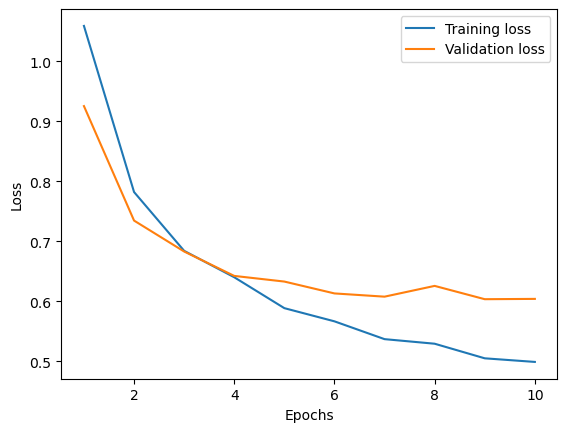

In [85]:
plt.plot(epochs, train_loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

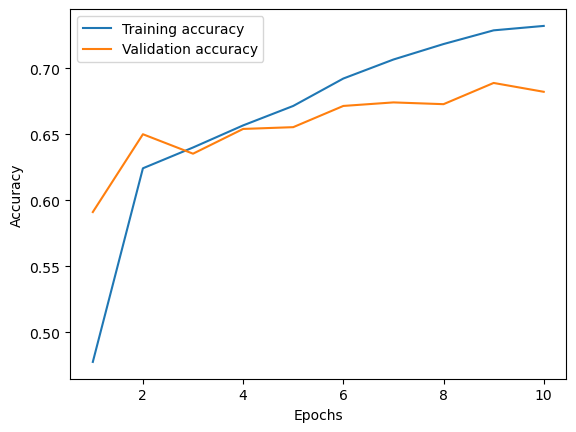

In [86]:
plt.plot(epochs, train_acc, label = 'Training accuracy')
plt.plot(epochs, val_acc, label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [88]:
# Test on an additional test set

full_pred=[]
full_label=[]
with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_dataloader:
                image = image.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label)
                running_loss += loss.item()
                val, index_ = torch.max(y_pred,axis=1)
                np_predclass=index_.cpu().numpy()
                np_trueclass=label.cpu().numpy()
                full_pred.extend(np_predclass)
                full_label.extend(np_trueclass)
                running_score += torch.sum(index_ == label.data).item()
          epoch_score = running_score/len(test_dataloader.dataset)
          epoch_loss = running_loss/len(test_dataloader)
          print("Test loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

Test loss: 0.535429336130619, accuracy: 0.677384780278671


In [89]:
from sklearn.metrics import confusion_matrix

<Axes: >

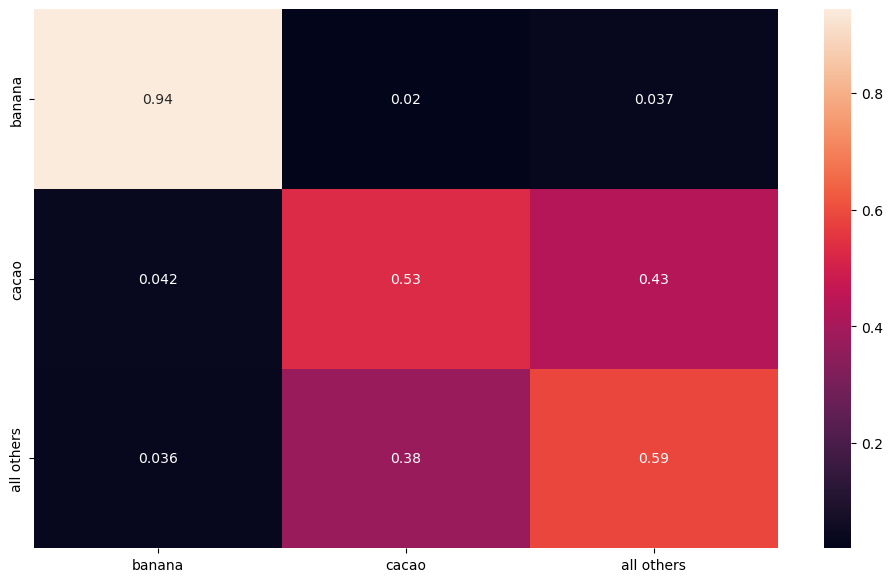

In [90]:
cf_matrix = confusion_matrix(full_label, full_pred)
classes=['banana','cacao','all others']
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)